In [1]:
# Reconstruct strain profiles from phase gradient information

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
from mbptycho.code.utils import circular_gradient
from mbptycho.code.simulation import reloadSimulation
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase
from skimage.feature import register_translation

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
strain_type = 'point_inclusion'
base_path =  f'/home/skandel/code/mbptycho/experiments/python/{strain_type}/'
sim_data_path = f'{base_path}/sim_{strain_type}.pkl'
sample_data_path = f'{base_path}/sample_{strain_type}.pkl'

probes_3d_path = '/home/skandel/code/mbptycho/experiments/matlab/datasets/probe_02.mat'

In [5]:
sm = reloadSimulation(sim_data_path, reload_sim=True, 
                      new_sim_params={'poisson_noise':True, 
                                      'probes_matlab_file':probes_3d_path},
                      new_extra_sample_params={'strain_type':strain_type})#sim_params={"HKL_list":[[1, 2, 0]]}

File exists. Reloading...


In [6]:
phases_recons = np.angle(np.load(base_path + '/rho_out.npz')['arr_0'])
phases_recons_unwrapped = np.array([unwrap_phase(p) for p in phases_recons])

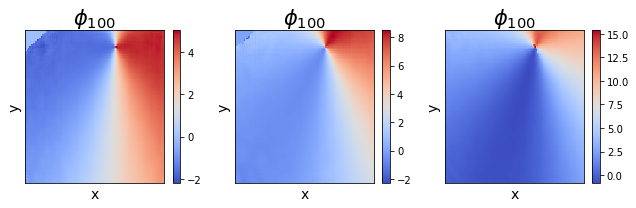

In [7]:
plt.figure(figsize=[9,3])
for i, arr in enumerate(phases_recons_unwrapped):
    plt.subplot(1,3,i+1)
    plt.pcolormesh(arr, cmap='coolwarm')#, vmin=-np.pi, vmax=np.pi)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.title(r"$\phi_{100}$", fontsize=21)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
#plt.colorbar()
plt.tight_layout()
plt.show()

In [15]:
def getGroundTruths():
    npix_x = np.sum(np.sum(sm.sample.obj_mask_trunc, axis=(0,2)) > 0) 
    npix_y = np.sum(np.sum(sm.sample.obj_mask_trunc, axis=(1,2)) > 0) 
    npix_z = np.sum(np.sum(sm.sample.obj_mask_trunc, axis=(0,1)) > 0)

    npix_xy = npix_x * npix_y

    nyr, nxr, nzr = sm.rhos[0].shape
    pady0 = np.where(sm.sample.obj_mask_trunc.sum(axis=(1,2)))[0][0]
    padx0 = np.where(sm.sample.obj_mask_trunc.sum(axis=(0,2)))[0][0]
    padz0 = np.where(sm.sample.obj_mask_trunc.sum(axis=(0,1)))[0][0]

    # These are the true values. Used for comparison and validation.
    pady0, padx0, nyvar, nxvar, nzvar = pady0, padx0, npix_y, npix_x, npix_z
    ux_test = sm.sample.Ux_trunc[..., nzvar // 2].copy()
    ux_test[~sm.sample.amplitudes_trunc_mask[..., nzvar // 2]] = 0
    ux_test = ux_test[pady0: pady0 + nyvar, padx0: padx0 + nxvar] / sm.sample.params.lattice[0]

    uy_test = sm.sample.Uy_trunc[..., nzvar // 2].copy()
    uy_test[~sm.sample.amplitudes_trunc_mask[...,nzvar//2]] = 0
    uy_test = uy_test[pady0: pady0 + nyvar, padx0: padx0 + nxvar] / sm.sample.params.lattice[0]
    return ux_test, uy_test

In [9]:
def get2DPhasesromNormalizedDisplacements(Ux_t, Uy_t):
    """Calculate the phase profile using the provided amplitudes and HKL list. 

    Sets the rhos for the sample class, and also returns the rhos.

    Assumes that the displacements are normalized w.r.t. to the lattice constant, i.e.
    Ux_t = Ux_t_actual / lattice[0]
    Uy_t = Uy_t_actual / lattice[1]
    Uz_t = Uz_t actual / lattice[2]

    Parameters
    ----------
    ...
    Returns
    -------
    """
    phases_all_t = []
    for H, K, L in sm.params.HKL_list:
        t1 = H * Ux_t + K * Uy_t   
        phase_t = 2 * np.pi * t1
        phases_all_t.append(phase_t)
    phases_all_t = tf.stack(phases_all_t)
    return phases_all_t

In [10]:
def get2DPhaseGradientsFromNormalizedDisplacements(ux_uy_2d_v):
    """Calculate the phase profile using the provided amplitudes and HKL list. 

    Sets the rhos for the sample class, and also returns the rhos.

    Assumes that the displacements are normalized w.r.t. to the lattice constant, i.e.
    Ux_t = Ux_t_actual / lattice[0]
    Uy_t = Uy_t_actual / lattice[1]
    Uz_t = Uz_t actual / lattice[2]

    Parameters
    ----------
    ...
    Returns
    -------
    """
    grads_ux, grads_uy = tf.squeeze(tf.image.image_gradients(ux_uy_2d_v[...,None]))
    
    phase_gradients_all_t = []
    for H, K, L in sm.params.HKL_list:
        t1 = H * grads_ux + K * grads_uy   
        phase_gradients_t = 2 * np.pi * t1
        phase_gradients_all_t.append(phase_gradients_t)
    phase_gradients_all_t = tf.stack(phase_gradients_all_t)
    return phase_gradients_all_t

In [47]:
ux_true, uy_true = getGroundTruths()

In [48]:
gradient_phases = np.array([circular_gradient(p) for p in phases_recons])
gradient_phases_yx = np.array([[g[1], g[0]] for g in gradient_phases])

In [49]:
ux_uy_v1 = tf.Variable(tf.zeros((2, 91, 147), dtype='float32'))
ux_uy_v2 = tf.Variable(tf.zeros((2, 91, 147), dtype='float32'))
phases_data_t = tf.constant(phases_recons_unwrapped, dtype='float32')
gradient_phases_data_t = tf.constant(gradient_phases_yx, dtype='float32')

In [50]:
lossfn1 = lambda : tf.reduce_mean((get2DPhasesromNormalizedDisplacements(ux_uy_v1[0], ux_uy_v1[1]) - phases_data_t)**2)
lossfn_grads = lambda: tf.reduce_mean((get2DPhaseGradientsFromNormalizedDisplacements(ux_uy_v2) - gradient_phases_data_t)**2)

In [51]:
lossfn_grads()

<tf.Tensor: shape=(), dtype=float32, numpy=0.029920882>

In [52]:
opt1 = tf.keras.optimizers.Adam(1e-1)
opt2 = tf.keras.optimizers.Adam(1e-1)

In [65]:
for i in range(10000):
    opt1.minimize(lossfn1, ux_uy_v1)
    opt2.minimize(lossfn_grads, ux_uy_v2)
    if i % 200 == 0: 
        ux1_out = ux_uy_v1[0].numpy() - ux_uy_v1[0].numpy().mean()
        uy1_out = ux_uy_v1[1].numpy() - ux_uy_v1[1].numpy().mean()
        ux2_out = ux_uy_v2[0].numpy() - ux_uy_v2[0].numpy().mean()
        uy2_out = ux_uy_v2[1].numpy() - ux_uy_v2[1].numpy().mean()
        
        
        _, e1, _ = register_translation(ux1_out, ux_true - ux_true.mean(), upsample_factor=10)
        _, e2, _ = register_translation(uy1_out, uy_true - uy_true.mean(), upsample_factor=10)
        _, e3, _ = register_translation(ux2_out, ux_true - ux_true.mean(), upsample_factor=10)
        _, e4, _ = register_translation(uy2_out, uy_true - uy_true.mean(), upsample_factor=10)
        print(lossfn1().numpy(), lossfn_grads().numpy(), e1, e1, e3, e4)

0.011783026 0.07926576 0.05531667467134776 0.05531667467134776 0.05735227307628359 0.09325043100027396
0.01185469 0.023686133 0.05531768383758974 0.05531768383758974 0.6784517057829335 0.8580258963260301
0.011864729 0.023360223 0.05517599896873427 0.05517599896873427 0.8638246879237896 0.9113864969537822
0.012119481 0.024850706 0.05531664501151622 0.05531664501151622 0.941654349820006 0.9019785293228832
0.011942368 0.02288319 0.05534646370041752 0.05534646370041752 0.9801192971462072 0.8858129249938359
0.011871063 0.022865307 0.05532728992866494 0.05532728992866494 0.9709641178442021 0.8462772510391622
0.011891985 0.023798147 0.05523674084397355 0.05523674084397355 0.9253394337651292 0.8118896299321654
0.011880243 0.021929936 0.05519783970213693 0.05519783970213693 0.8718316184987276 0.7814259412306102
0.012246477 0.023707904 0.055464634336508535 0.055464634336508535 0.8171997960338018 0.7540010582477614
0.011896772 0.023984604 0.0552789359922619 0.0552789359922619 0.7656097407247205 0

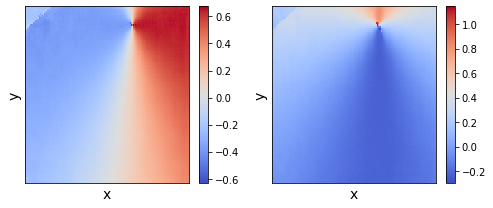

In [66]:
plt.figure(figsize=[7,3])
for i, arr in enumerate([ux1_out, uy1_out]):
    plt.subplot(1,2,i+1)
    plt.pcolormesh(arr, cmap='coolwarm')#, vmin=-np.pi, vmax=np.pi)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    #plt.title(r"$\phi_{100}$", fontsize=21)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

plt.tight_layout()
plt.show()

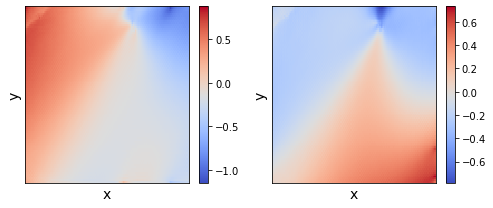

In [67]:
plt.figure(figsize=[7,3])
for i, arr in enumerate([ux2_out, uy2_out]):
    plt.subplot(1,2,i+1)
    plt.pcolormesh(arr, cmap='coolwarm')#, vmin=-np.pi, vmax=np.pi)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    #plt.title(r"$\phi_{100}$", fontsize=21)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

plt.tight_layout()
plt.show()

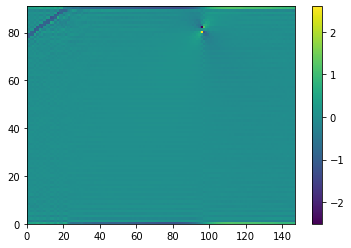

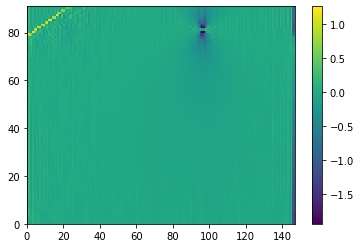

In [ ]:
for p in gradient_phases_data_t:
    for p1 in p:
        plt.figure()
        plt.pcolormesh(p1)
        plt.colorbar()